### TD3: univariate GANs for financial time series 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.pylab as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

    

In [4]:
data = pd.read_csv('HK_logret.csv.gz')
data.set_index('Unnamed: 0', inplace=True)
data.index.name = 'Date'
data.index = pd.to_datetime(data.index)
data.head(2)

,0417.HK,2638.HK,0275.HK,0040.HK,0084.HK,0840.HK,0248.HK,0641.HK,0309.HK,1202.HK,...,0868.HK,0856.HK,1135.HK,0883.HK,0817.HK,1207.HK,3768.HK,0538.HK,0346.HK,8228.HK
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.0,NaN,NaN,-0.074115,-0.064532,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,-0.026451,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = data.loc[data.index > '2010-01-01']

In [6]:
def largest_continuous_non_nan_series(column):
    max_len = 0
    max_start = 0
    current_len = 0
    current_start = 0
    in_series = False
    
    for i in range(len(column)):
        if not pd.isna(column.iloc[i]):
            if not in_series:
                in_series = True
                current_start = i
            current_len += 1
        else:
            if in_series:
                in_series = False
                if current_len > max_len:
                    max_len = current_len
                    max_start = current_start
                current_len = 0
                
    if in_series and current_len > max_len:
        max_len = current_len
        max_start = current_start
        
    return column[max_start:max_start+max_len]

In [7]:
dic = {col : largest_continuous_non_nan_series(df[col]) for col in df.columns}

Does it have na? 

In [8]:
there_are_nan= False
T = 252

columns_to_drop = []
for key in dic.keys():
    if len(dic[key]) < T:
        columns_to_drop.append(key)
        continue
    
    if dic[key].isna().any():
        there_are_nan = True
        break
print("There are nan:", there_are_nan)
print("columns to drop:", len(columns_to_drop))

for col in columns_to_drop:
    del dic[col]

There are nan: False
columns to drop: 32


### build random sampler



In [9]:
def get_arrays_of_rets(dic : dict, batch_size : int, T : int) -> list:
    assets = list(dic.keys())
    list_of_rets = []
    for i in range(batch_size):
        asset = random.choice(assets)
        j = random.randint(0, len(dic[asset]) - T)
        list_of_rets.append(dic[asset].iloc[j:j+T].values)
    return list_of_rets

### Build models

In [10]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense, Activation, Reshape,Flatten, Dropout, Lambda, RepeatVector
from tensorflow.keras.layers import Add,Multiply
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling1D, Conv1D
from tensorflow.keras.layers import LeakyReLU


def generator_model_mlp(dim_output,dim_noise,use_bias=False):
    generator = Sequential()
    generator.add(Input(shape=(dim_noise,)))
    generator.add(Dense(dim_noise, use_bias=use_bias))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Dense(dim_noise, use_bias=use_bias))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Dense(dim_output, use_bias=use_bias))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Dense(dim_output, activation='tanh'))
    return generator

def discriminator_model_mlp(T, activation="leakyrelu"):    
    discriminator = Sequential()
    discriminator.add(Input(shape=(T,)))
    discriminator.add(Dense(T ))
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Dense(T // 2))
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Dense(T // 4))
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Dense(1, activation="sigmoid"))
    return discriminator



In [11]:
T = 252
dim_noise = T * 2


generator=generator_model_mlp(T,dim_noise,use_bias=False)


discriminator=discriminator_model_mlp(T)


INIT_LR = 3e-4

opt_discriminator = Adam(learning_rate=INIT_LR/10, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt_discriminator)

discriminator.summary()

c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 252)            │        63,756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 252)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 126)            │        31,878 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 63)             │         8,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,699 (405.07 KB)

 Trainable params: 103,699 (405.07 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
discriminator.trainable = False

ganInput = Input(shape=(dim_noise,))
ganOutput = discriminator(generator(ganInput))
gan = Model(ganInput, ganOutput)

# compile the GAN
opt_gan = Adam(learning_rate=INIT_LR, beta_1=0.5)#, decay=INIT_LR / NUM_EPOCHS)
gan.compile(loss="binary_crossentropy", optimizer=opt_gan)

gan.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 504)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 252)            │       703,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       103,699 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 807,535 (3.08 MB)

 Trainable params: 701,316 (2.68 MB)

 Non-trainable params: 106,219 (414.92 KB)

In [13]:
size_data = sum([len(dic[asset]) for asset in dic.keys()])
size_data

1770757

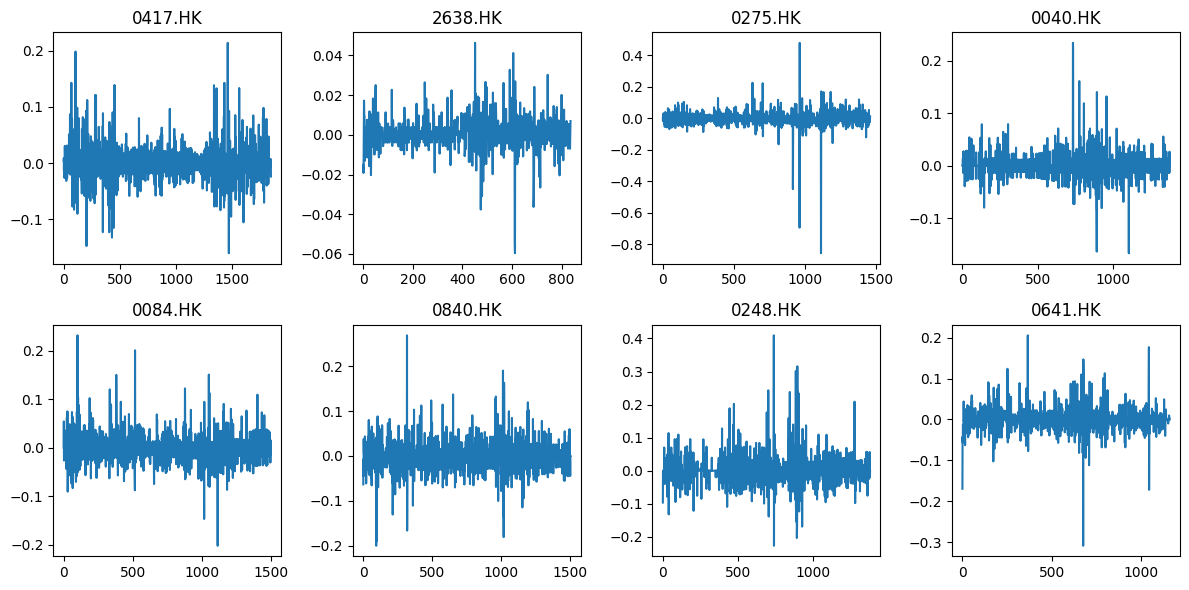

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
assets = list(dic.keys())[:4*2]

for i, ax in enumerate(axs.flatten()):
    asset = assets[i]
    ax.plot(dic[asset].values)
    ax.set_title(asset)

plt.tight_layout()
plt.show()

In [15]:
asset = list(dic.keys())[2]
rets = dic[asset].values

In [16]:
from sklearn.utils import shuffle

size_data = sum([len(dic[asset]) for asset in dic.keys()])

num_epochs=2000                                  # interrupt at any time
batch_size=100
num_batches_per_epoch=int(size_data/batch_size)

losses=[]                                         

# because these two cells are split, you can stop the for myepoch... loop and start it again without 
# losing the model and the loss history

In [ ]:
for myepoch in range(num_epochs):
    print("epoch "+str(myepoch+1)+"/"+str(num_epochs))
    for batch in range(num_batches_per_epoch//10):
        etas=np.random.normal(size=(batch_size,dim_noise))

        preds=generator.predict(etas)

        t0s=np.random.choice(num_batches_per_epoch,size=batch_size)
        rets_sample= get_arrays_of_rets(dic,batch_size,T)
        #rets_sample=[rets[range(i,i+T)] for i in np.random.choice(len(rets)-T,size=batch_size)]
        rets_sample=np.array(rets_sample)         # list -> 2d-array
        X=np.concatenate((np.reshape(preds,(preds.shape[0],preds.shape[1])),rets_sample))
        y=np.append(np.full(batch_size,0),np.full(batch_size,1))
        
        (X,y)=shuffle(X,y)   # otherwise the discriminator learns the order

        X=np.expand_dims(X, axis=2)
        y=np.expand_dims(y,1)      
        
        discriminator.trainable=True
        
        print(X.shape)
        print(y.shape)
        
        discriminator_loss=discriminator.train_on_batch(X, y)    # improves discriminator classifiation abilities
                                                                 # this temporarilly unfreezes the discr. weights
        etas=np.random.normal(size=(batch_size,dim_noise))       # generate more samples from the generator
        y_fake=np.full(etas.shape[0],1)

        discriminator.trainable=False
        gan_loss = gan.train_on_batch(etas,y_fake)               # trains the generator

    new_losses=[gan_loss,discriminator_loss]
    print(new_losses)
    losses.append(np.array(new_losses))

epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(200, 252, 1)
(200, 1)


AttributeError: 'NoneType' object has no attribute 'update_state'

In [ ]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("losses")
#plt.savefig("losses_mlp_vs_time_nobias.pdf")

In [ ]:
etas=np.random.normal(size=(1000,dim_noise))   # 1000 generate timeseries
#etas=np.random.standard_t(3,size=(1000,dim_noise))/np.sqrt(3)  # are we allowed to do this?

# generate more samples from the generator
preds=generator.predict(etas)
pred0=generator.predict(np.reshape(np.zeros(dim_noise),(1,dim_noise)))    # what happens if eta=(0,...,0)?

In [ ]:
plt.rc('font', family='serif')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('text', usetex=True)

In [ ]:
rets_GAN=preds.flatten()

### some useful bits of code

In [ ]:
import seaborn as sns
sns.lineplot(range(len(rets_GAN)),rets_GAN)    



In [ ]:
sns.kdeplot(rets_GAN)           # kernel density estimator
plt.yscale("log")


In [ ]:
# convexity check of 1-ecdf(|r_t|)

from statsmodels.distributions.empirical_distribution import ECDF

myECDF=ECDF(np.abs(rets_GAN)[:100000])
sns.lineplot(myECDF.x,1-myECDF.y)
plt.xscale("linear")
plt.yscale("log")
plt.plot()

In [ ]:
# fit of powerlaw to |r_t|
import powerlaw
myfit=powerlaw.Fit(np.abs(rets_GAN[10000:20000]))
myfit.plot_ccdf()
print(myfit.alpha)

In [ ]:
np.exp(np.mean(np.log(discriminator.predict(preds))))   # average prob that the generated timeseries 
                                                        # are mistaken for real ones

In [ ]:
 # best generated timeseries
    
idx_best=np.array(np.where(np.max(discriminator.predict(preds))==discriminator.predict(preds)))[0][0]  

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
plt.plot((preds[idx_best,:]),color='k', ls='solid')
ax.set_xlabel('t')
ax.set_ylabel('generated price')
plt.title("best synthetic timeseries for $\eta_1$")


## Additional bits of code: playing with  the discriminator



In [ ]:
ntries=100

X_gauss=np.resize(np.random.normal(size=T*ntries),(ntries,T))
          
y_gauss=discriminator.predict(np.expand_dims(X_gauss, axis=2)).flatten()

The discriminator clearly finds that this is not a lookalike timeseries

In [ ]:
sns.kdeplot(y_gauss)
plt.title("Gaussian i.i.d, unit variance")
plt.xlabel("$prob_{discr}$(True)")


In [ ]:
y_gauss_rescaled=discriminator.predict(np.expand_dims(X_gauss*np.std(rets),axis=2)).flatten()
sns.kdeplot(y_gauss_rescaled)
plt.xlabel("$prob_{discr}$(True)")
plt.title("Gaussian i.i.d, rescaled")


In [ ]:
X_student=np.random.standard_t(3,size=(ntries,T))/np.sqrt(3)           

y_student=discriminator.predict(np.expand_dims(X_student, axis=2)).flatten()
sns.kdeplot(y_student)
plt.xlabel("$prob_{discr}$(True)")

plt.title("Student-t (nu=3) i.i.d, unit variance")


Now with the original returns

In [ ]:
t0s=np.random.choice(num_batches_per_epoch,size=batch_size)
rets_sample=[rets[range(i,i+T)] for i in np.random.choice(len(rets)-T,size=batch_size)]
rets_sample=np.array(rets_sample)         # list -> 2d-array
X_sample=rets_sample

y_sample=discriminator.predict(np.expand_dims(X_sample,axis=2)).flatten()

sns.kdeplot(y_sample)
plt.xlabel("$prob_{discr}$(True)")
plt.title("real returns")


Compare GANs with i.i.d. log returns from Gauss and Student t distributions


In [ ]:
y_gan=discriminator.predict(preds).flatten()

fig, ax = plt.subplots()

sns.kdeplot(y_gauss_rescaled,ax=ax,label="Gauss")
sns.kdeplot(y_gan,ax=ax,label="GAN")
sns.kdeplot(y_student_rescaled,ax=ax,label="Student-t i.i.d scaled")

plt.xlabel("$prob_{discr}$(True)")
plt.title("GAN returns")
plt.legend()

Is the discriminator able to recognize another financial timeseries?

In [ ]:
import yfinance

TSLA=yfinance.Ticker("TSLA").history(start="2010-01-01",auto_adjust=True)


In [ ]:
ret_TSLA=np.array(np.log(TSLA["Close"]).diff())
ret_TSLA=ret_TSLA-np.nanmean(ret_TSLA)
ret_TSLA=ret_TSLA/np.nanstd(ret_TSLA)
rets_sample=[ret_TSLA[range(i,i+T)] for i in np.random.choice(len(ret_TSLA)-T,size=batch_size)]
rets_sample=np.array(rets_sample)         # list -> 2d-array
X_sample=rets_sample
y_ret=discriminator.predict(np.expand_dims(X_sample,axis=2)).flatten()

In [ ]:
sns.kdeplot(y_ret)
plt.xlabel("$prob_{discr}$(True)")
plt.title("TSLA returns")
plt.savefig("mlp_nobias_T500_Ptrue_realTSLAret.pdf")